# Model Training- Home Credit Default Risk dataset 

The data was provided by Home Credit through a Kaggle competition with the objective of predicting whether or not a loan applicant will be able to repay the leaned amount. Thus, this is a supervised classification task.

In this notebook, the data will be treated to a minimum level that would be sufficient enough for a Random Forest Classifier to be applied. The results of this model will serve as comparison for a further and more complex model that will be used after a series of data transformations.

## Initial imports and data load

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, quantile_transform
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pickle

import os

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')

def plot_roc_curve(fpr, tpr, y_true, y_score):
    plt.title('Receiver Operating Characteristic: {:.3}'.format(roc_auc_score(y_true, y_score)))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7")
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [2]:
%pwd

'/Users/gabrielestivalet/Desktop/Python/Udacity-Nanodegree/ML_Engineering/projects/capstone/credit_default_risk'

In [3]:
data = pd.read_csv("data_sampled.csv")

In [4]:
data.shape

(81362, 247)

### PCA

In [5]:
# Separating numerical and categorical columns
descriptions = pd.read_csv("data_description.csv", index_col=0).loc[:,'dtype']
print(descriptions.shape)

(129,)


In [6]:
numerical_cols   = descriptions.index[descriptions != 'object'].tolist()

categorical_cols = list()
for col in data.columns:
    if col not in numerical_cols:
        categorical_cols.append(col)

numerical_cols.remove('TARGET')        
        
X_nums = data.loc[:,numerical_cols]
X_cats = data.loc[:,categorical_cols]
y = data['TARGET']

In [7]:
print(X_nums.shape, X_cats.shape)

(81362, 83) (81362, 168)


### Robust Scaler & PCA

In [39]:
scaler = RobustScaler()
scaler.fit(X_nums)
X_scaled = scaler.transform(X_nums)

pca_rs = PCA(n_components=X_nums.shape[1])
pca_rs.fit(X_scaled)

X_pca_robustscaler = pca_rs.transform(X_scaled)

print("original features' shape: {}".format(X_nums.shape))
print("pca-transformed features' shape: {}".format(X_pca_robustscaler.shape))

original features' shape: (81362, 83)
pca-transformed features' shape: (81362, 83)


### PCA analysis

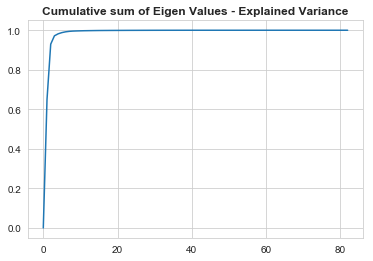

In [40]:
cumulative_sum_eigenv_rs = [pd.Series(pca_rs.explained_variance_ratio_)[:i].sum() for i in range(83)]

pd.Series(cumulative_sum_eigenv_rs).plot()
plt.title('Cumulative sum of Eigen Values - Explained Variance', fontweight='bold');

In [42]:
pd.Series(pca_rs.explained_variance_ratio_)[:3].sum()

0.9718191196510315

As we can see, when the RobustScaler is applied to the data, the first 3 components are enough to capture around 98% of the continuous cols variability. So, this the PCA will be fitted again to produce this many components.

In [82]:
pca_rs = PCA(n_components=3)
pca_rs.fit(X_scaled)

X_pca_robustscaler = pca_rs.transform(X_scaled)

print("original features' shape: {}".format(X_nums.shape))
print("pca-transformed features' shape: {}".format(X_pca_robustscaler.shape))

original features' shape: (81362, 83)
pca-transformed features' shape: (81362, 3)


### Quantile transform & PCA

In [43]:
X_quantile = quantile_transform(X_nums, output_distribution="normal")

pca_qt = PCA(n_components=X_nums.shape[1])
pca_qt.fit(X_quantile)

X_pca_qt = pca_qt.transform(X_quantile)

print("original features' shape: {}".format(X_nums.shape))
print("pca-transformed features' shape: {}".format(X_pca_qt.shape))

original features' shape: (81362, 83)
pca-transformed features' shape: (81362, 83)


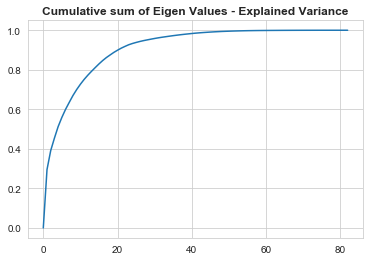

In [44]:
cumulative_sum_eigenv_qt = [pd.Series(pca_qt.explained_variance_ratio_)[:i].sum() for i in range(83)]

pd.Series(cumulative_sum_eigenv_qt).plot()
plt.title('Cumulative sum of Eigen Values - Explained Variance', fontweight='bold');

In [87]:
pd.Series(pca.explained_variance_ratio_)[:36].sum()

0.9715197309648151

On the other hand, when a quantile_tranform is used to normalize the continuous variables, many more principal components are needed to capture a similar variability. In this case, 36 components seem to be enough to capture most of it. There are dimisishing returns when more components are added. This way, 36 will be used to retrain the PCA on the normalized data.

In [88]:
pca_qt = PCA(n_components=36)
pca_qt.fit(X_quantile)

X_pca_qt = pca_qt.transform(X_quantile)

print("original features' shape: {}".format(X_nums.shape))
print("pca-transformed features' shape: {}".format(X_pca_qt.shape))

original features' shape: (81362, 83)
pca-transformed features' shape: (81362, 36)


### Feature Selection for categorical features

In [51]:
rf = RandomForestClassifier(n_estimators=500, max_features=10, random_state=101, n_jobs=4)
rf.fit(X_cats, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=101, verbose=0, warm_start=False)

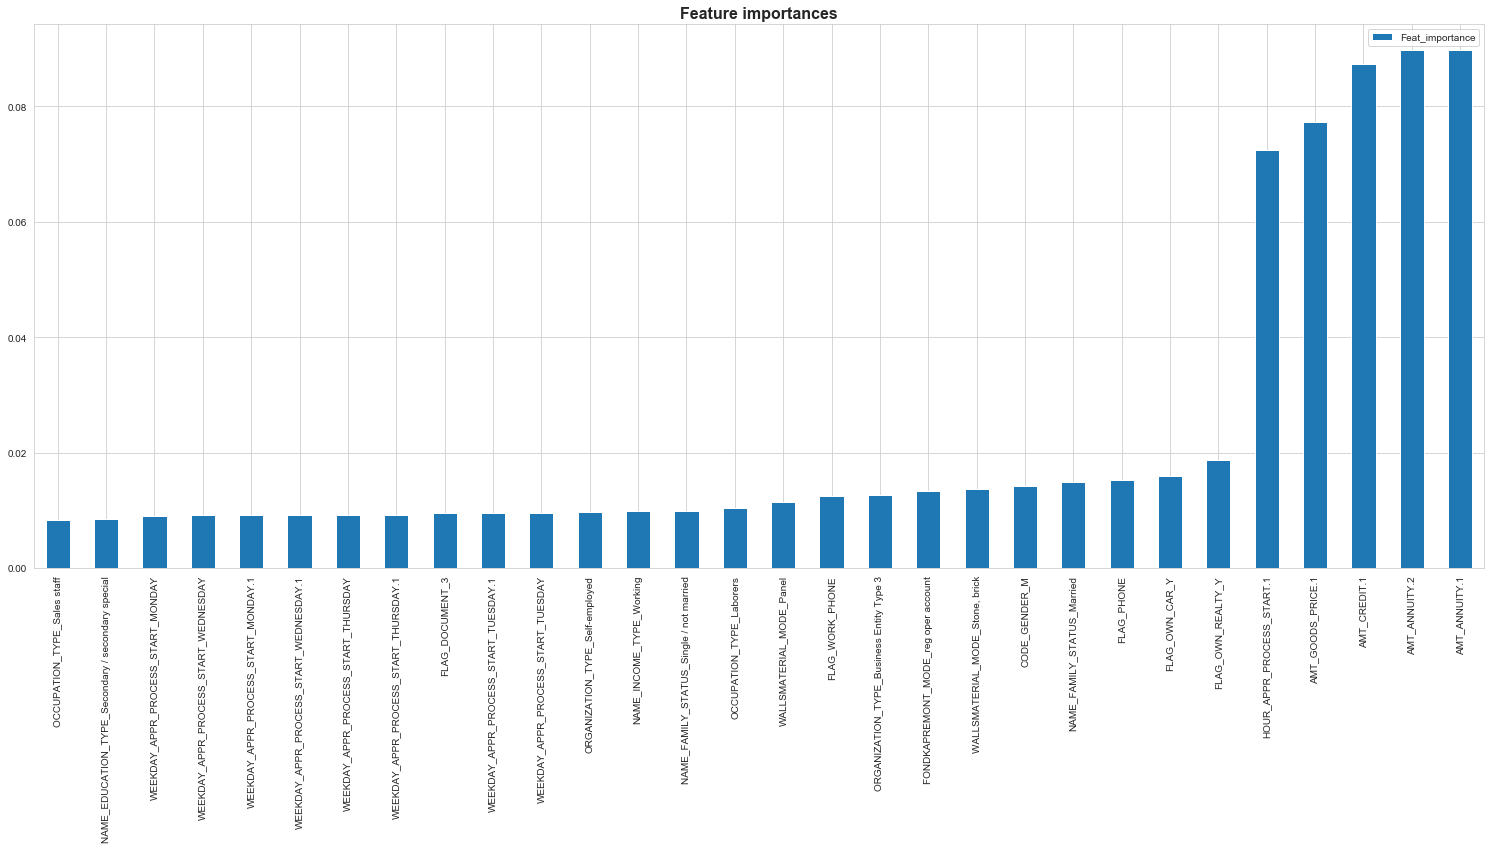

In [52]:
# Feature Importances
features = {}
for feature, importance in zip(X_cats.columns, rf.feature_importances_):
    features[feature] = importance

importances = ((pd.DataFrame.from_dict(features, orient='index')
                            .rename(columns={0: 'Feat_importance'}))
               .sort_values(by='Feat_importance').tail(30))

importances.plot(kind='bar', rot=90, figsize=(26,10))    
plt.title("Feature importances", fontsize=16, fontweight='bold')
plt.show()

As suspected, only a handful of the categorical features have a higher discriminatory power. This way, a feature selection may turn the dataset smaller, while retaining most of its informative power.

In [8]:
rf = RandomForestClassifier(n_estimators=1000, max_features=10, random_state=101)

select_feats = SelectFromModel(rf, threshold="1.5*median")
select_feats.fit(X_cats, y)
X_cats_selected = select_feats.transform(X_cats)

print("X_cats: {}".format(X_cats.shape))
print("X_cats_selected: {}".format(X_cats_selected.shape))

X_cats: (81362, 168)
X_cats_selected: (81362, 68)


Text(0.5,0,'Sample index')

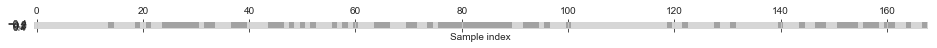

In [9]:
mask = select_feats.get_support()
plt.matshow(mask.reshape(1,-1), cmap="gray_r")
plt.xlabel("Sample index")

# Model 1: original dataset

In [68]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25,
                                                    stratify=y, random_state=101)
print(X_train1.shape)
print(X_test1.shape)

# Model
rf = RandomForestClassifier(n_estimators = 1000)

params = {"max_depth": [3, 5, 9, 13],
          "max_features": range(5,21,3),
          "min_samples_split": range(4,20,4),
          "min_samples_leaf": range(4,20,4),
          "bootstrap": [True, False],
          "criterion": ["gini", "entropy"]}

rscv1 = RandomizedSearchCV(rf, param_distributions=params, cv=5,
                          n_jobs=3, scoring='roc_auc', random_state=101)
rscv1.fit(X_train1, y_train1)

# Saving the model
pickle.dump(rscv1, open('model1.sav', 'wb'))

(61021, 246)
(20341, 246)


In [77]:
rscv1 = pickle.load(open('models/model1.sav','rb'))
rscv1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Model1 Performance Evaluation

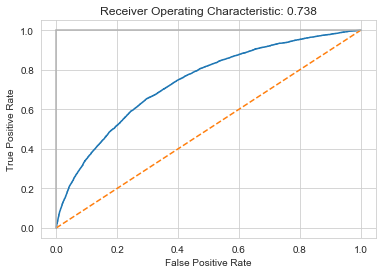

In [79]:
y_pred_proba1 = rscv1.best_estimator_.predict_proba(X_test1)[:,1]

# Create true and false positive rates
fpr1, tpr1, threshold1 = roc_curve(y_test1, y_pred_proba1)

plot_roc_curve(fpr1, tpr1, y_test1, y_pred_proba1)

In [80]:
y_pred1 = rscv1.best_estimator_.predict(X_test1)

confusion_matrix(y_test1, y_pred1)

array([[13742,   393],
       [ 5280,   926]])

In [81]:
print(classification_report(y_test1, y_pred1))

             precision    recall  f1-score   support

          0       0.72      0.97      0.83     14135
          1       0.70      0.15      0.25      6206

avg / total       0.72      0.72      0.65     20341



# Model2: RobustScaler + PCA + SelectFromModel

In [90]:
X2 = np.hstack((X_pca_robustscaler, X_cats_selected))
y2 = data['TARGET']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25,
                                                    stratify=y2, random_state=101)
print(X_train2.shape)
print(X_test2.shape)

# Model
rf = RandomForestClassifier(n_estimators = 1000)

params = {"max_depth": [3, 5, 9, 13],
          "max_features": range(5,21,3),
          "min_samples_split": range(4,20,4),
          "min_samples_leaf": range(4,20,4),
          "bootstrap": [True, False],
          "criterion": ["gini", "entropy"]}

rscv2 = RandomizedSearchCV(rf, param_distributions=params, cv=5,
                          n_jobs=3, scoring='roc_auc', random_state=101)
rscv2.fit(X_train2, y_train2)

# Saving the model
pickle.dump(rscv2, open('model2.sav', 'wb'))

(61021, 71)
(20341, 71)


In [3]:
rscv2 = pickle.load(open('models/model2.sav','rb'))
rscv2.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Model2 Performance Evaluation

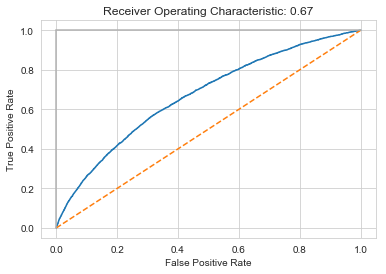

In [91]:
y_pred_proba2 = rscv2.best_estimator_.predict_proba(X_test2)[:,1]

# Create true and false positive rates
fpr2, tpr2, threshold2 = roc_curve(y_test2, y_pred_proba2)

plot_roc_curve(fpr2, tpr2, y_test2, y_pred_proba2)

In [92]:
y_pred2 = rscv2.best_estimator_.predict(X_test2)

confusion_matrix(y_test2, y_pred2)

array([[13693,   442],
       [ 5532,   674]])

In [93]:
print(classification_report(y_test2, y_pred2))

             precision    recall  f1-score   support

          0       0.71      0.97      0.82     14135
          1       0.60      0.11      0.18      6206

avg / total       0.68      0.71      0.63     20341



# Model3: quantile_transform + PCA + SelectFromModel

In [94]:
X3 = np.hstack((X_pca_qt, X_cats_selected))
y3 = data['TARGET']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25,
                                                    stratify=y3, random_state=101)
print(X_train3.shape)
print(X_test3.shape)

# Model
rf = RandomForestClassifier(n_estimators = 1000)

params = {"max_depth": [3, 5, 9, 13],
          "max_features": range(5,21,3),
          "min_samples_split": range(4,20,4),
          "min_samples_leaf": range(4,20,4),
          "bootstrap": [True, False],
          "criterion": ["gini", "entropy"]}

rscv3 = RandomizedSearchCV(rf, param_distributions=params, cv=5,
                          n_jobs=3, scoring='roc_auc', random_state=101)
rscv3.fit(X_train3, y_train3)

# Saving the model
pickle.dump(rscv3, open('model3.sav', 'wb'))

(61021, 104)
(20341, 104)


In [4]:
rscv3 = pickle.load(open('models/model3.sav','rb'))
rscv3.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Model3 Performance Evaluation

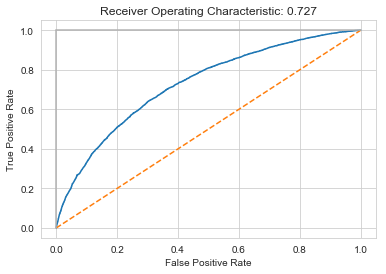

In [95]:
y_pred_proba3 = rscv3.best_estimator_.predict_proba(X_test3)[:,1]

# Create true and false positive rates
fpr3, tpr3, threshold3 = roc_curve(y_test3, y_pred_proba3)

plot_roc_curve(fpr3, tpr3, y_test3, y_pred_proba3)

In [96]:
y_pred3 = rscv3.best_estimator_.predict(X_test3)

confusion_matrix(y_test3, y_pred3)

array([[13505,   630],
       [ 5018,  1188]])

In [97]:
print(classification_report(y_test3, y_pred3))

             precision    recall  f1-score   support

          0       0.73      0.96      0.83     14135
          1       0.65      0.19      0.30      6206

avg / total       0.71      0.72      0.67     20341



# Model4: original continuous features + SelectFromModel

In [18]:
#X4 = pd.DataFrame(np.hstack((X_nums, X_cats_selected)))
#X4.head()
print(type(X_nums))
print(type(X_cats_selected))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [98]:
X4 = np.hstack((X_nums, X_cats_selected))
y4 = data['TARGET']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.25,
                                                    stratify=y4, random_state=101)
print(X_train4.shape)
print(X_test4.shape)

# Model
rf = RandomForestClassifier(n_estimators = 1000)

params = {"max_depth": [3, 5, 9, 13],
          "max_features": range(5,21,3),
          "min_samples_split": range(4,20,4),
          "min_samples_leaf": range(4,20,4),
          "bootstrap": [True, False],
          "criterion": ["gini", "entropy"]}

rscv4 = RandomizedSearchCV(rf, param_distributions=params, cv=5,
                          n_jobs=3, scoring='roc_auc', random_state=101)
rscv4.fit(X_train4, y_train4)

# Saving the model
pickle.dump(rscv4, open('model4.sav', 'wb'))

(61021, 151)
(20341, 151)


In [11]:
rscv4 = pickle.load(open('models/model4.sav','rb'))
rscv4.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Model4 Performance Evaluation

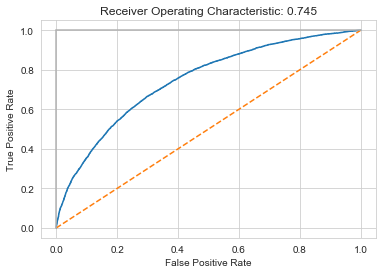

In [99]:
y_pred_proba4 = rscv4.best_estimator_.predict_proba(X_test4)[:,1]

# Create true and false positive rates
fpr4, tpr4, threshold4 = roc_curve(y_test4, y_pred_proba4)

plot_roc_curve(fpr4, tpr4, y_test4, y_pred_proba4)

In [100]:
y_pred4 = rscv4.best_estimator_.predict(X_test4)

confusion_matrix(y_test4, y_pred4)

array([[13506,   629],
       [ 4829,  1377]])

In [101]:
print(classification_report(y_test4, y_pred4))

             precision    recall  f1-score   support

          0       0.74      0.96      0.83     14135
          1       0.69      0.22      0.34      6206

avg / total       0.72      0.73      0.68     20341



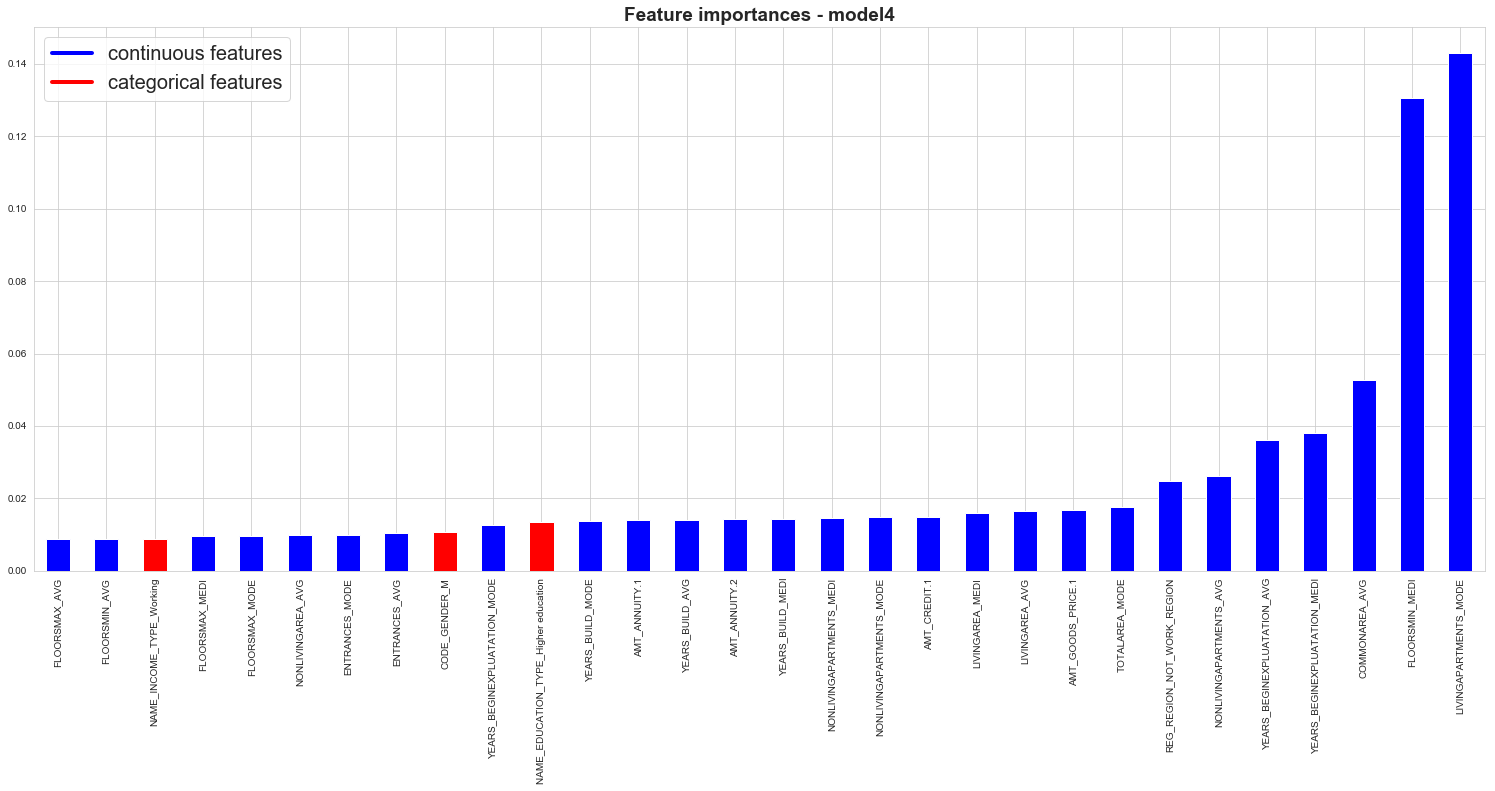

In [15]:
# Feature Importances
features = {}

col_names = list(X_nums.columns) + list(X_cats.columns[mask])

for feature, importance in zip(col_names, rscv4.best_estimator_.feature_importances_):
    features[feature] = importance

importances = ((pd.DataFrame.from_dict(features, orient='index')
                            .rename(columns={0: 'Feat_importance'}))
               .sort_values(by='Feat_importance').tail(30))

feat_importances_model4 = pd.merge(importances, pd.DataFrame(descriptions), how='left',
                                   left_index=True, right_index=True)
feat_importances_model4.loc['AMT_ANNUITY.1','dtype'] = 'float64'
feat_importances_model4.loc['AMT_ANNUITY.2','dtype'] = 'float64'
feat_importances_model4.loc['AMT_CREDIT.1','dtype'] = 'float64'
feat_importances_model4.loc['AMT_GOODS_PRICE.1','dtype'] = 'float64'
feat_importances_model4.loc['CODE_GENDER_M','dtype'] = 'object'
feat_importances_model4.loc['NAME_EDUCATION_TYPE_Higher education','dtype'] = 'object'
feat_importances_model4.loc['NAME_INCOME_TYPE_Working','dtype'] = 'object'

color_schema = {'float64':'blue','int64':'blue','object':'red'}

feat_importances_model4.sort_values(by="Feat_importance", inplace=True)
feat_importances_model4['Feat_importance'].plot(kind='bar', rot=90, figsize=(26,10),
                color=feat_importances_model4['dtype'].apply(lambda x: color_schema[x]))    
plt.title("Feature importances - model4", fontsize=19, fontweight='bold')

legend_elem = [Line2D([0], [0], color='b', lw=4, label='continuous features'),
               Line2D([0], [0], color='r', lw=4, label='categorical features')]

plt.legend(handles=legend_elem, loc=2, fontsize=20)
plt.show()